# Introduction

This project applies Machine Learning to an IMDB database of 5000 movies. The goal is to predict the revenue of a movie at a level that is helpful to a studio. Since the costs of movies differ widely I will evaluate my revenue prediction against profit margin. 

In order to define a metric for this project I will estimate profit margin for the movies. This will be done assuming that the total budget for a movie can be estimated by doubling the production budget of that movie<sup>1</sup>. I will find out the standard deviation of profit margin for the movies in this dataset and attempt to predict revenue to within 1/4 of a standard deviation of the spread of the profit margin in the dataset. I assume that it would be helpful for movie executives to prevent the worst loses in their portfolio and also avoid underbudgeting strong performers, that is the reason for choosing this metric. 

<sup>1</sup> https://stephenfollows.com/how-movies-make-money-hollywood-blockbusters/

## Library Imports

In [1]:
# These are all the libraries I want to use for initial analysis. I will import scikit libraries later.
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 100)

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

In [79]:
# Scikit libraries

# For genres feature engineering
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.exceptions import NotFittedError

## Exploratory Analysis

Will do exploratory analysis here. Will take notes as I go:
* Some movies lost a lot of money otherwise, the distribution looks vaguely normal but the movies that lost a lot of money are making the STD very high
* Data issue, the gross figures are only profits in the US. Wikipedia states on Princess Mononoke: Princess Mononoke was the highest-grossing Japanese film of 1997, earning ¥11.3 billion in distribution receipts. It became the highest-grossing film in Japan until it was surpassed by Titanic several months later. The film earned a domestic total of ¥19.3 billion. It was the top-grossing anime film in the United States in January 2001, but despite this the film did not fare as well financially in the country when released in December 1997. It grossed 2,298,191 dollars for the first eight weeks. The IBDB database has 2,298,191 for it's gross. We will need to remove all of the non-US titles. Luckily we didn't lose too much data. 3074 vs. 3891. The data becomes very normal after removing non-US titles!
* Many of the features show pareto like distributions including: all facebook like features, all number of reviews features, movie budget, and movie gross,
* A data issue, there are 762 different kinds of genres. This is because each combination of features for example 'Action|Adventure|Fantasy|Sci-Fi'. I need to see if there is a way to seperate out these different genres, and allow movies to belong to different combinations of genres.
* Tags has the same issue as above but there are likely too many tags even when seperated to be useful. 
* For some reason in the color category ' Black and White' has a space at the beginning
* We ought to combine all of the content ratings that are not G, PG, PG13, and R into an 'Other' category
* There are only 16 non-english movies, this feature should be removed to avoid overfitting
* The highest correlation of movie gross is with budget of the movie and with the number of reviews either users or critics, however the number of reviews is not something that we would have before a movie comes out so is of limited predictive value. We'll want to try predicting with and without these number of review features. The next highest correlations are with social media likes (for the movie and for the actors / directors), and with IMDB score; our estimated profit feature is not much correlated with anything but gross and IMDB score, our estimated profitability is not correlated with anything in the dataset.
* Our STD after removing duplicates, non-USA movies, and movies with no gross or budget information is 68,779,390; so we'll see if we can predict movies to within 17 M. 

In [3]:
# Importing the IMBD 5000 Database
initial_df = pd.read_csv('movie_metadata.csv')
initial_df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
# Check for empty features
initial_df.isnull().sum()

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [5]:
# Remove entries with null gross and null budget, since profit margin cannot be calculcated on those movies
initial_df.dropna(subset=['gross', 'budget'], inplace=True)
initial_df.isnull().sum()

color                         2
director_name                 0
num_critic_for_reviews        1
duration                      1
director_facebook_likes       0
actor_3_facebook_likes       10
actor_2_name                  5
actor_1_facebook_likes        3
gross                         0
genres                        0
actor_1_name                  3
movie_title                   0
num_voted_users               0
cast_total_facebook_likes     0
actor_3_name                 10
facenumber_in_poster          6
plot_keywords                31
movie_imdb_link               0
num_user_for_reviews          0
language                      3
country                       0
content_rating               51
budget                        0
title_year                    0
actor_2_facebook_likes        5
imdb_score                    0
aspect_ratio                 75
movie_facebook_likes          0
dtype: int64

In [6]:
# Drop duplications
initial_df.drop_duplicates()
initial_df.shape

(3891, 28)

In [7]:
# Create a feature estimating total budget
initial_df['total_budget'] = initial_df.budget*2

# Create a feature estimating profit
initial_df['profit'] = (initial_df.gross - initial_df.total_budget)

initial_df.profit.describe()

count    3.891000e+03
mean    -3.936556e+07
std      4.431208e+08
min     -2.442880e+10
25%     -4.815942e+07
50%     -1.499937e+07
75%      2.001106e+06
max      4.389357e+08
Name: profit, dtype: float64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-438935700.0, 438935700.0)

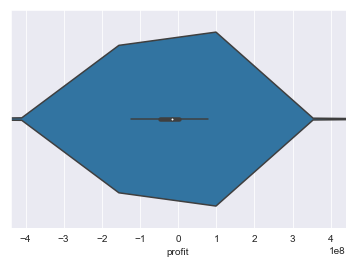

In [8]:
sns.violinplot(x=initial_df.profit)
plt.xlim(-4.389357e+08, 4.389357e+08)

In [9]:
initial_df[initial_df.profit < -4.389357e+08]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,total_budget,profit
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,212204,1873,Polly Walker,1.0,alien|american civil war|male nipple|mars|prin...,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,738.0,English,USA,PG-13,2.637000e+08,2012.0,632.0,6.6,2.35,24000,5.274000e+08,-4.543413e+08
1016,Color,Luc Besson,111.0,158.0,0.0,15.0,David Bailie,51.0,14131298.0,Adventure|Biography|Drama|History|War,Paul Brooke,The Messenger: The Story of Joan of Arc,55889,144,Rab Affleck,0.0,cathedral|dauphin|france|trial|wartime rape,http://www.imdb.com/title/tt0151137/?ref_=fn_t...,390.0,English,France,R,3.900000e+08,1999.0,40.0,6.4,2.35,0,7.800000e+08,-7.658687e+08
1338,Color,John Woo,160.0,150.0,610.0,478.0,Tony Chiu Wai Leung,755.0,626809.0,Action|Adventure|Drama|History|War,Takeshi Kaneshiro,Red Cliff,36894,2172,Wei Zhao,4.0,alliance|battle|china|chinese|strategy,http://www.imdb.com/title/tt0425637/?ref_=fn_t...,105.0,Mandarin,China,R,5.536320e+08,2008.0,643.0,7.4,2.35,0,1.107264e+09,-1.106637e+09
2323,Color,Hayao Miyazaki,174.0,134.0,6000.0,745.0,Jada Pinkett Smith,893.0,2298191.0,Adventure|Animation|Fantasy,Minnie Driver,Princess Mononoke,221552,2710,Billy Crudup,0.0,anime|cult film|forest|princess|studio ghibli,http://www.imdb.com/title/tt0119698/?ref_=fn_t...,570.0,Japanese,Japan,PG-13,2.400000e+09,1997.0,851.0,8.4,1.85,11000,4.800000e+09,-4.797702e+09
2334,Color,Katsuhiro Ôtomo,105.0,103.0,78.0,101.0,Robin Atkin Downes,488.0,410388.0,Action|Adventure|Animation|Family|Sci-Fi|Thriller,William Hootkins,Steamboy,13727,991,Rosalind Ayres,1.0,19th century|ball|boy|inventor|steam,http://www.imdb.com/title/tt0348121/?ref_=fn_t...,79.0,Japanese,Japan,PG-13,2.127520e+09,2004.0,336.0,6.9,1.85,973,4.255040e+09,-4.254629e+09
2740,Color,Tony Jaa,110.0,110.0,0.0,7.0,Petchtai Wongkamlao,64.0,102055.0,Action,Nirut Sirichanya,Ong-bak 2,24570,134,Sarunyu Wongkrachang,0.0,cult film|elephant|jungle|martial arts|stylize...,http://www.imdb.com/title/tt0785035/?ref_=fn_t...,72.0,Thai,Thailand,R,3.000000e+08,2008.0,45.0,6.2,2.35,0,6.000000e+08,-5.998979e+08
2988,Color,Joon-ho Bong,363.0,110.0,584.0,74.0,Kang-ho Song,629.0,2201412.0,Comedy|Drama|Horror|Sci-Fi,Doona Bae,The Host,68883,1173,Ah-sung Ko,0.0,daughter|han river|monster|river|seoul,http://www.imdb.com/title/tt0468492/?ref_=fn_t...,279.0,Korean,South Korea,R,1.221550e+10,2006.0,398.0,7.0,1.85,7000,2.443100e+10,-2.442880e+10
3005,Color,Lajos Koltai,73.0,134.0,45.0,0.0,Péter Fancsikai,9.0,195888.0,Drama|Romance|War,Marcell Nagy,Fateless,5603,11,Bálint Péntek,0.0,bus|death|gay slur|hatred|jewish,http://www.imdb.com/title/tt0367082/?ref_=fn_t...,45.0,Hungarian,Hungary,R,2.500000e+09,2005.0,2.0,7.1,2.35,607,5.000000e+09,-4.999804e+09
3075,Color,Karan Johar,20.0,193.0,160.0,860.0,John Abraham,8000.0,3275443.0,Drama,Shah Rukh Khan,Kabhi Alvida Naa Kehna,13998,10822,Preity Zinta,2.0,extramarital affair|fashion magazine editor|ma...,http://www.imdb.com/title/tt0449999/?ref_=fn_t...,264.0,Hindi,India,R,7.000000e+08,2006.0,1000.0,6.0,2.35,659,1.400000e+09,-1.396725e+09
3273,Color,Anurag Basu,41.0,90.0,116.0,303.0,Steven Michael Quezada,594.0,1602466.0,Action|Drama|Romance|Thriller,Bárbara Mori,Kites,9673,1836,Kabir Bedi,0.0,casino|desert|love|suicide|tragic event,http://www.imdb.com/title/tt1198101/?ref_=fn_t...,106.0,English,India,NaN,6.000000e+08,2010.0,412.0,6.0,NaN,0,1.200000e+09,-1.198398e+09


In [10]:
# Create a profitability feature
initial_df['profitability'] = initial_df.profit/initial_df.total_budget
initial_df.profitability.describe()

count    3891.000000
mean        2.126874
std        64.811208
min        -0.999991
25%        -0.774477
50%        -0.464672
75%         0.114270
max      3596.242767
Name: profitability, dtype: float64

In [11]:
initial_df.country.unique()

array(['USA', 'UK', 'New Zealand', 'Canada', 'Australia', 'Germany',
       'China', 'New Line', 'France', 'Japan', 'Spain', 'Hong Kong',
       'Czech Republic', 'Peru', 'South Korea', 'India', 'Aruba',
       'Denmark', 'Belgium', 'Ireland', 'South Africa', 'Italy',
       'Romania', 'Chile', 'Netherlands', 'Hungary', 'Russia', 'Mexico',
       'Greece', 'Taiwan', 'Official site', 'Thailand', 'Iran',
       'West Germany', 'Georgia', 'Iceland', 'Brazil', 'Finland',
       'Norway', 'Argentina', 'Colombia', 'Poland', 'Israel', 'Indonesia',
       'Afghanistan', 'Sweden', 'Philippines'], dtype=object)

In [12]:
initial_df=initial_df[initial_df.country=='USA']
print(initial_df.country.unique())
print(initial_df.shape)

['USA']
(3074, 31)


count    3.074000e+03
mean    -2.277299e+07
std      6.877939e+07
min     -4.543413e+08
25%     -4.814359e+07
50%     -1.372147e+07
75%      4.430857e+06
max      4.389357e+08
Name: profit, dtype: float64


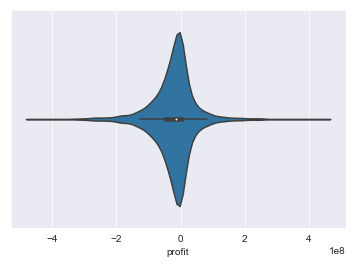

In [13]:
print(initial_df.profit.describe())
sns.violinplot(x=initial_df.profit)

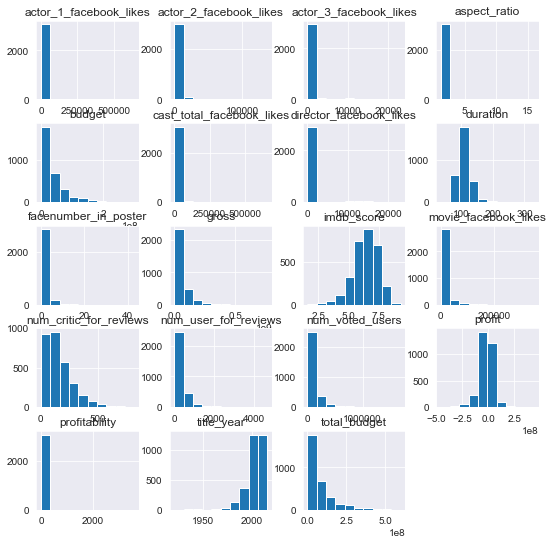

In [14]:
initial_df.hist(figsize=(9,9))
plt.show()

In [15]:
initial_df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,total_budget,profit,profitability
count,3073.000000,3074.000000,3074.000000,3069.000000,3073.000000,3.074000e+03,3.074000e+03,3074.000000,3068.000000,3074.000000,3.074000e+03,3074.000000,3072.000000,3074.000000,3016.000000,3074.000000,3.074000e+03,3.074000e+03,3074.000000
mean,163.213798,109.348081,902.680547,830.920495,8197.561341,5.728945e+07,1.075269e+05,12264.236825,1.420795,333.592062,4.003122e+07,2003.022121,2164.829102,6.385947,2.100368,9324.176643,8.006243e+07,-2.277299e+07,2.720936
std,125.215125,22.122647,3318.949966,1992.130817,16673.921347,7.275710e+07,1.576255e+05,20370.534286,2.136960,410.223499,4.379910e+07,10.007002,4792.751633,1.052057,0.372138,21746.579013,8.759821e+07,6.877939e+07,72.892644
min,1.000000,34.000000,0.000000,0.000000,0.000000,7.030000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1920.000000,0.000000,1.600000,1.180000,0.000000,4.360000e+02,-4.543413e+08,-0.999907
25%,72.000000,95.000000,11.000000,229.000000,799.000000,1.141309e+07,1.846150e+04,2171.500000,0.000000,106.000000,1.000000e+07,1999.000000,427.000000,5.800000,1.850000,0.000000,2.000000e+07,-4.814359e+07,-0.718644
50%,133.000000,105.000000,60.500000,466.000000,2000.000000,3.379975e+07,5.409850e+04,4479.000000,1.000000,207.000000,2.500000e+07,2004.000000,726.000000,6.500000,2.350000,249.000000,5.000000e+07,-1.372147e+07,-0.396683
75%,221.000000,119.000000,234.750000,723.000000,13000.000000,7.486365e+07,1.305638e+05,16800.000000,2.000000,397.000000,5.475000e+07,2010.000000,1000.000000,7.100000,2.350000,11000.000000,1.095000e+08,4.430857e+06,0.192774
max,813.000000,330.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,4667.000000,3.000000e+08,2016.000000,137000.000000,9.300000,16.000000,349000.000000,6.000000e+08,4.389357e+08,3596.242767


In [16]:
initial_df.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

In [17]:
initial_df.describe(include=['object'])

,color,director_name,actor_2_name,genres,actor_1_name,movie_title,actor_3_name,plot_keywords,movie_imdb_link,language,country,content_rating
count,3073,3074,3072,3074,3073,3074,3069,3055,3074,3071,3074,3052
unique,2,1419,1821,656,1185,2993,2153,2974,2993,11,1,11
top,Color,Steven Spielberg,Morgan Freeman,Comedy,Robert De Niro,Halloween,Anne Hathaway,eighteen wheeler|illegal street racing|truck|t...,http://www.imdb.com/title/tt1976009/?ref_=fn_t...,English,USA,R
freq,2983,23,16,138,38,3,7,3,3,3055,3074,1334


In [18]:
initial_df.genres.unique()

array(['Action|Adventure|Fantasy|Sci-Fi', 'Action|Adventure|Fantasy',
       'Action|Thriller', 'Action|Adventure|Sci-Fi',
       'Action|Adventure|Romance',
       'Adventure|Animation|Comedy|Family|Fantasy|Musical|Romance',
       'Action|Adventure|Western', 'Action|Adventure|Family|Fantasy',
       'Action|Adventure|Comedy|Family|Fantasy|Sci-Fi',
       'Action|Adventure|Drama|History', 'Adventure|Fantasy',
       'Adventure|Family|Fantasy', 'Drama|Romance',
       'Action|Adventure|Sci-Fi|Thriller',
       'Action|Adventure|Fantasy|Romance',
       'Adventure|Animation|Comedy|Family|Fantasy',
       'Adventure|Animation|Comedy|Family|Sport', 'Action|Crime|Thriller',
       'Action|Adventure|Horror|Sci-Fi|Thriller',
       'Action|Adventure|Fantasy|Sci-Fi|Thriller',
       'Adventure|Animation|Family|Sci-Fi',
       'Action|Comedy|Crime|Thriller', 'Animation|Drama|Family|Fantasy',
       'Action|Adventure|Drama|Romance', 'Action|Crime|Drama|Thriller',
       'Adventure|Animation|Com

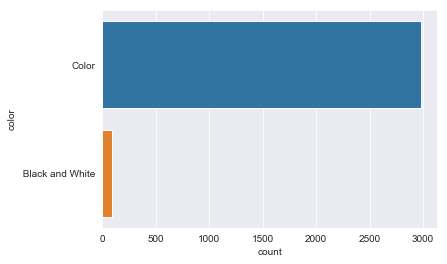

In [19]:
sns.countplot(y=initial_df.color)

In [20]:
initial_df.color.unique()

array(['Color', ' Black and White', nan], dtype=object)

In [21]:
initial_df[initial_df.color==' Black and White'].shape

(90, 31)

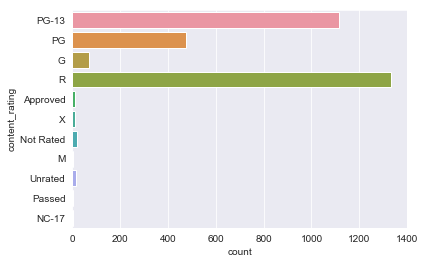

In [22]:
sns.countplot(y='content_rating', data=initial_df)

In [23]:
initial_df[initial_df.content_rating=='Not Rated'].shape

(19, 31)

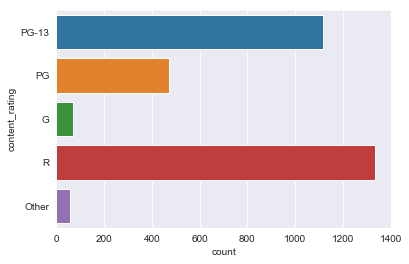

In [24]:
initial_df.content_rating.replace(to_replace=['Approved', 'X', 'Not Rated', 'M', 'Unrated', 'Passed', 'NC-17'], value='Other', inplace=True)
sns.countplot(y='content_rating', data=initial_df)

In [25]:
initial_df[initial_df.language!='English']

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,total_budget,profit,profitability
484,Color,Martin Campbell,137.0,129.0,258.0,163.0,Nick Chinlund,2000.0,45356386.0,Action|Adventure|Western,Michael Emerson,The Legend of Zorro,71574,2864,Adrian Alonso,1.0,california|fight|hero|mask|zorro,http://www.imdb.com/title/tt0386140/?ref_=fn_t...,244.0,Spanish,USA,PG,75000000.0,2005.0,277.0,5.9,2.35,951,150000000.0,-104643614.0,-0.697624
811,Black and White,John Dahl,81.0,132.0,131.0,242.0,Clayne Crawford,11000.0,10166502.0,Action|Drama|War,James Franco,The Great Raid,18209,12133,Paolo Montalban,0.0,american|lieutenant colonel|mission|rescue|sol...,http://www.imdb.com/title/tt0326905/?ref_=fn_t...,183.0,Filipino,USA,R,80000000.0,2005.0,298.0,6.7,2.35,0,160000000.0,-149833498.0,-0.936459
1236,Color,Mel Gibson,283.0,139.0,0.0,19.0,Dalia Hernández,708.0,50859889.0,Action|Adventure|Drama|Thriller,Rudy Youngblood,Apocalypto,236000,848,Jonathan Brewer,0.0,jaguar|mayan|solar eclipse|tribe|village,http://www.imdb.com/title/tt0472043/?ref_=fn_t...,1043.0,Maya,USA,R,40000000.0,2006.0,78.0,7.8,1.85,14000,80000000.0,-29140111.0,-0.364251
1866,Color,Mel Gibson,406.0,120.0,0.0,113.0,Maia Morgenstern,260.0,499263.0,Drama,Christo Jivkov,The Passion of the Christ,179235,705,Hristo Shopov,0.0,anti semitism|cult film|grindhouse|suffering|t...,http://www.imdb.com/title/tt0335345/?ref_=fn_t...,2814.0,Aramaic,USA,R,30000000.0,2004.0,252.0,7.1,2.35,13000,60000000.0,-59500737.0,-0.991679
2259,Color,Marc Forster,201.0,128.0,395.0,161.0,Shaun Toub,283.0,15797907.0,Drama,Mustafa Haidari,The Kite Runner,68119,904,Khalid Abdalla,0.0,afghanistan|based on novel|boy|friend|kite,http://www.imdb.com/title/tt0419887/?ref_=fn_t...,230.0,Dari,USA,PG-13,20000000.0,2007.0,206.0,7.6,2.35,0,40000000.0,-24202093.0,-0.605052
2863,Color,Clint Eastwood,251.0,141.0,16000.0,78.0,Kazunari Ninomiya,378.0,13753931.0,Drama|History|War,Yuki Matsuzaki,Letters from Iwo Jima,132149,751,Shidô Nakamura,0.0,blood splatter|general|island|japan|world war two,http://www.imdb.com/title/tt0498380/?ref_=fn_t...,316.0,Japanese,USA,R,19000000.0,2006.0,85.0,7.9,2.35,5000,38000000.0,-24246069.0,-0.638054
2890,Color,Angelina Jolie Pitt,110.0,127.0,11000.0,116.0,Nikola Djuricko,306.0,301305.0,Drama|Romance|War,Jelena Jovanova,In the Land of Blood and Honey,31414,796,Branko Djuric,0.0,bosnian war|church|emaciation|soldier|violence,http://www.imdb.com/title/tt1714209/?ref_=fn_t...,180.0,Bosnian,USA,R,13000000.0,2011.0,164.0,4.3,2.35,0,26000000.0,-25698695.0,-0.988411
3086,Color,Christopher Cain,43.0,111.0,58.0,258.0,Taylor Handley,482.0,1066555.0,Drama|History|Romance|Western,Jon Gries,September Dawn,2618,1526,Trent Ford,0.0,massacre|mormon|settler|utah|wagon train,http://www.imdb.com/title/tt0473700/?ref_=fn_t...,111.0,NaN,USA,R,11000000.0,2007.0,362.0,5.8,1.85,411,22000000.0,-20933445.0,-0.951520
3455,Color,Siddharth Anand,16.0,153.0,5.0,60.0,Mary Goggin,532.0,872643.0,Comedy|Family|Romance,Saif Ali Khan,Ta Ra Rum Pum,2909,902,Vic Aviles,3.0,comeback|family relationships|marriage|new yor...,http://www.imdb.com/title/tt0833553/?ref_=fn_t...,37.0,Hindi,USA,NaN,6000000.0,2007.0,249.0,5.4,NaN,108,12000000.0,-11127357.0,-0.927280
3614,Color,Matt Piedmont,133.0,84.0,4.0,546.0,Adrian Martinez,8000.0,5895238.0,Comedy|Western,Will Ferrell,Casa de mi Padre,17169,10123,Luis E. Carazo,1.0,absurd humor|drug lord|mexico|ranch|spaghetti ...,http://www.imdb.com/title/tt1702425/?ref_=fn_t...,70.0,Spanish,USA,R,6000000.0,2012.0,806.0,5.5,2.35,9000,12000000.0,-6104762.0,-0.508730


In [26]:
correlations=initial_df.corr()

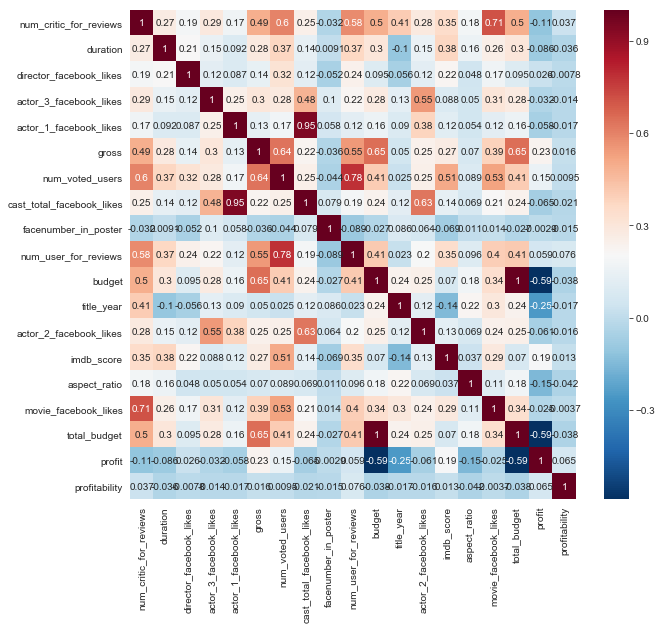

In [27]:
# Increase the figsize to 10 x 9
plt.figure(figsize=(10,9))

# Plot heatmap of correlations
sns.heatmap(correlations, annot=True, cmap='RdBu_r', )

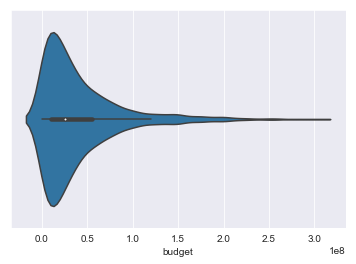

In [28]:
sns.violinplot(initial_df.budget)

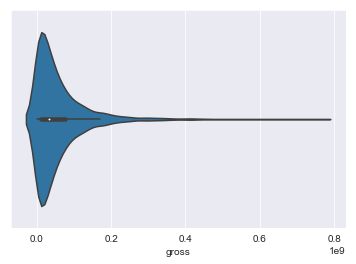

In [29]:
sns.violinplot(initial_df.gross)

## Data Cleaning

I will create a new DataFrame and clean the data on that by: removing duplicates, removing entries without budget or gross values, addressing missing data, dropping non-US movies (which have incorrect gross values), addressing sparse data.

In [30]:
df = initial_df = pd.read_csv('movie_metadata.csv')
df.shape

(5043, 28)

In [31]:
# Remove duplicates and entries without budget or gross
df.dropna(subset=['gross', 'budget'], inplace=True)
df.drop_duplicates()
print(df.shape)
print(df.isnull().sum())

(3891, 28)
color                         2
director_name                 0
num_critic_for_reviews        1
duration                      1
director_facebook_likes       0
actor_3_facebook_likes       10
actor_2_name                  5
actor_1_facebook_likes        3
gross                         0
genres                        0
actor_1_name                  3
movie_title                   0
num_voted_users               0
cast_total_facebook_likes     0
actor_3_name                 10
facenumber_in_poster          6
plot_keywords                31
movie_imdb_link               0
num_user_for_reviews          0
language                      3
country                       0
content_rating               51
budget                        0
title_year                    0
actor_2_facebook_likes        5
imdb_score                    0
aspect_ratio                 75
movie_facebook_likes          0
dtype: int64


In [32]:
# Replace null values of categorical values: 
df.color.fillna('Missing', inplace=True)
df.actor_2_name.fillna('Missing', inplace=True)
df.actor_1_name.fillna('Missing', inplace=True)
df.actor_3_name.fillna('Missing', inplace=True)
df.plot_keywords.fillna('Missing', inplace=True)
df.content_rating.fillna('Missing', inplace=True)
df.aspect_ratio.fillna('Missing', inplace=True)
df.language.fillna('Missing', inplace=True)
print(df.isnull().sum())

color                         0
director_name                 0
num_critic_for_reviews        1
duration                      1
director_facebook_likes       0
actor_3_facebook_likes       10
actor_2_name                  0
actor_1_facebook_likes        3
gross                         0
genres                        0
actor_1_name                  0
movie_title                   0
num_voted_users               0
cast_total_facebook_likes     0
actor_3_name                  0
facenumber_in_poster          6
plot_keywords                 0
movie_imdb_link               0
num_user_for_reviews          0
language                      0
country                       0
content_rating                0
budget                        0
title_year                    0
actor_2_facebook_likes        5
imdb_score                    0
aspect_ratio                  0
movie_facebook_likes          0
dtype: int64


In [33]:
# Fill missing data for numerical features
df['num_critic_for_reviews_missing'] = df.num_critic_for_reviews.isnull().astype(int)
df.num_critic_for_reviews.fillna(0, inplace=True)

df['duration_missing'] = df.duration.isnull().astype(int)
df.duration.fillna(0, inplace=True)

df['actor_1_facebook_likes_missing'] = df.actor_1_facebook_likes.isnull().astype(int)
df.actor_1_facebook_likes.fillna(0, inplace=True)

df['actor_2_facebook_likes_missing'] = df.actor_2_facebook_likes.isnull().astype(int)
df.actor_2_facebook_likes.fillna(0, inplace=True)

df['actor_3_facebook_likes_missing'] = df.actor_3_facebook_likes.isnull().astype(int)
df.actor_3_facebook_likes.fillna(0, inplace=True)

df['facenumber_in_poster_missing'] = df.facenumber_in_poster.isnull().astype(int)
df.facenumber_in_poster.fillna(0, inplace=True)

print(df.isnull().sum())

color                             0
director_name                     0
num_critic_for_reviews            0
duration                          0
director_facebook_likes           0
actor_3_facebook_likes            0
actor_2_name                      0
actor_1_facebook_likes            0
gross                             0
genres                            0
actor_1_name                      0
movie_title                       0
num_voted_users                   0
cast_total_facebook_likes         0
actor_3_name                      0
facenumber_in_poster              0
plot_keywords                     0
movie_imdb_link                   0
num_user_for_reviews              0
language                          0
country                           0
content_rating                    0
budget                            0
title_year                        0
actor_2_facebook_likes            0
imdb_score                        0
aspect_ratio                      0
movie_facebook_likes        

In [34]:
df.dtypes

color                              object
director_name                      object
num_critic_for_reviews            float64
duration                          float64
director_facebook_likes           float64
actor_3_facebook_likes            float64
actor_2_name                       object
actor_1_facebook_likes            float64
gross                             float64
genres                             object
actor_1_name                       object
movie_title                        object
num_voted_users                     int64
cast_total_facebook_likes           int64
actor_3_name                       object
facenumber_in_poster              float64
plot_keywords                      object
movie_imdb_link                    object
num_user_for_reviews              float64
language                           object
country                            object
content_rating                     object
budget                            float64
title_year                        

In [35]:
# Remove any non-US films and also remove country column
df=df[df.country=='USA']
df.drop(columns=['country'], inplace=True)
print(df.shape)
print(df.columns)

(3074, 33)
Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'content_rating',
       'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'aspect_ratio', 'movie_facebook_likes',
       'num_critic_for_reviews_missing', 'duration_missing',
       'actor_1_facebook_likes_missing', 'actor_2_facebook_likes_missing',
       'actor_3_facebook_likes_missing', 'facenumber_in_poster_missing'],
      dtype='object')


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


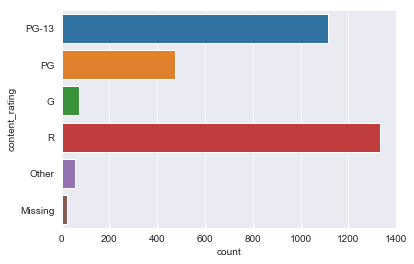

In [36]:
# Replace sparse content_rating features with 'Other'
df.content_rating.replace(to_replace=['Approved', 'X', 'Not Rated', 'M', 'Unrated', 'Passed', 'NC-17'], value='Other', inplace=True)
sns.countplot(y='content_rating', data=df)

In [37]:
# Dropping Language Column because everything besides english is sparse so I don't want this feature to cause overfitting
df.drop(['language'], axis=1, inplace=True)
print(df.shape)
print(df.columns)

(3074, 32)
Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'content_rating', 'budget',
       'title_year', 'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'num_critic_for_reviews_missing',
       'duration_missing', 'actor_1_facebook_likes_missing',
       'actor_2_facebook_likes_missing', 'actor_3_facebook_likes_missing',
       'facenumber_in_poster_missing'],
      dtype='object')


## Feature Engineering

Some feature engineering possibilities:
* Need to create dummy features for the categories
* See if I can create movie genre features from the current movie genre's feature which is organized poorly - done
* Possibly see if there is some way to seperate out big budget smaller budget movies - can't think of anything that wouldn't be accounted for already by budget
* Maybe keep the most popular directors and actors, that way we don't increase the dimensionality too much but we keep some actor and director information

In [38]:
# Creating more useful movie genre feature with a list of the genres
df['genres_list'] = df.genres.str.split('|')
df.genres_list.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    [Action, Adventure, Fantasy, Sci-Fi]
1            [Action, Adventure, Fantasy]
3                      [Action, Thriller]
5             [Action, Adventure, Sci-Fi]
6            [Action, Adventure, Romance]
Name: genres_list, dtype: object

In [39]:
s = df['genres_list']

mlb = MultiLabelBinarizer()

genres_list_df = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)

genres_list_df.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [40]:
abt = pd.concat([df, genres_list_df], axis=1)
abt.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,num_critic_for_reviews_missing,duration_missing,actor_1_facebook_likes_missing,actor_2_facebook_likes_missing,actor_3_facebook_likes_missing,facenumber_in_poster_missing,genres_list,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,0,0,0,0,0,0,"[Action, Adventure, Fantasy, Sci-Fi]",1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,0,0,0,0,0,0,"[Action, Adventure, Fantasy]",1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,0,0,0,0,0,0,"[Action, Thriller]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,212204,1873,Polly Walker,1.0,alien|american civil war|male nipple|mars|prin...,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,738.0,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,0,0,0,0,0,0,"[Action, Adventure, Sci-Fi]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,J.K. Simmons,Spider-Man 3,383056,46055,Kirsten Dunst,0.0,sandman|spider man|symbiote|venom|villain,http://www.imdb.com/title/tt0413300/?ref_=fn_t...,1902.0,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0,0,0,0,0,0,0,"[Action, Adventure, Romance]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [41]:
abt.dtypes

color                              object
director_name                      object
num_critic_for_reviews            float64
duration                          float64
director_facebook_likes           float64
actor_3_facebook_likes            float64
actor_2_name                       object
actor_1_facebook_likes            float64
gross                             float64
genres                             object
actor_1_name                       object
movie_title                        object
num_voted_users                     int64
cast_total_facebook_likes           int64
actor_3_name                       object
facenumber_in_poster              float64
plot_keywords                      object
movie_imdb_link                    object
num_user_for_reviews              float64
content_rating                     object
budget                            float64
title_year                        float64
actor_2_facebook_likes            float64
imdb_score                        

In [42]:
abt.drop(columns=['genres', 'genres_list'], inplace=True)
abt.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'movie_title',
       'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'num_critic_for_reviews_missing',
       'duration_missing', 'actor_1_facebook_likes_missing',
       'actor_2_facebook_likes_missing', 'actor_3_facebook_likes_missing',
       'facenumber_in_poster_missing', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'W

In [43]:
top_30_directors_df = abt.groupby(['director_name']).size().reset_index(name ='Count').sort_values('Count').tail(30)
top_30_directors=list(top_30_directors_df.director_name)
print(top_30_directors)

['Francis Ford Coppola', 'M. Night Shyamalan', 'Dennis Dugan', 'John McTiernan', 'Bobby Farrelly', 'Richard Linklater', 'Oliver Stone', 'Kevin Smith', 'Sam Raimi', 'Tony Scott', 'David Fincher', 'Rob Cohen', 'Rob Reiner', 'Robert Rodriguez', 'John Carpenter', 'Shawn Levy', 'Ron Howard', 'Wes Craven', 'Michael Bay', 'Barry Levinson', 'Robert Zemeckis', 'Ridley Scott', 'Renny Harlin', 'Woody Allen', 'Steven Soderbergh', 'Spike Lee', 'Tim Burton', 'Martin Scorsese', 'Clint Eastwood', 'Steven Spielberg']


In [44]:
top_30_actors_df = abt.groupby(['actor_1_name']).size().reset_index(name ='Count').sort_values('Count').tail(30)
top_30_actors = list(top_30_actors_df.actor_1_name)
print(top_30_actors)

['Julia Roberts', 'Brad Pitt', 'Paul Walker', 'Joseph Gordon-Levitt', 'Hugh Jackman', 'Matthew McConaughey', 'Liam Neeson', 'Gerard Butler', 'Leonardo DiCaprio', 'Channing Tatum', 'Dwayne Johnson', 'Will Smith', 'Morgan Freeman', 'Kevin Spacey', 'Will Ferrell', 'Tom Cruise', 'Keanu Reeves', 'Steve Buscemi', 'Tom Hanks', 'Robin Williams', 'Robert Downey Jr.', 'Bill Murray', 'Harrison Ford', 'Bruce Willis', 'Matt Damon', 'Nicolas Cage', 'Denzel Washington', 'J.K. Simmons', 'Johnny Depp', 'Robert De Niro']


In [45]:
abt.loc[~abt['director_name'].isin(top_30_directors), 'director_name'] = np.nan
abt.head(10)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,num_critic_for_reviews_missing,duration_missing,actor_1_facebook_likes_missing,actor_2_facebook_likes_missing,actor_3_facebook_likes_missing,facenumber_in_poster_missing,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Color,NaN,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Color,NaN,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Color,NaN,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,Color,NaN,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Daryl Sabara,John Carter,212204,1873,Polly Walker,1.0,alien|american civil war|male nipple|mars|prin...,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,738.0,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,J.K. Simmons,Spider-Man 3,383056,46055,Kirsten Dunst,0.0,sandman|spider man|symbiote|venom|villain,http://www.imdb.com/title/tt0413300/?ref_=fn_t...,1902.0,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,Color,NaN,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Brad Garrett,Tangled,294810,2036,M.C. Gainey,1.0,17th century|based on fairy tale|disney|flower...,http://www.imdb.com/title/tt0398286/?ref_=fn_t...,387.0,PG,260000000.0,2010.0,553.0,7.8,1.85,29000,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
8,Color,NaN,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Chris Hemsworth,Avengers: Age of Ultron,462669,92000,Scarlett Johansson,4.0,artificial intelligence|based on comic book|ca...,http://www.imdb.com/title/tt2395427/?ref_=fn_t...,1117.0,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
10,Color,NaN,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,330249062.0,Henry Cavill,Batman v Superman: Dawn of Justice,371639,24450,Alan D. Purwin,0.0,based on comic book|batman|sequel to a reboot|...,http://www.imdb.com/title/tt2975590/?ref_=fn_t...,3018.0,PG-13,250000000.0,2016.0,4000.0,6.9,2.35,197000,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
11,Color,NaN,434.0,169.0,0.0,903.0,Marlon Brando,18000.0,200069408.0,Kevin Spacey,Superman Returns,240396,29991,Frank Langella,0.0,crystal|epic|lex luthor|lois lane|return to earth,http://www.imdb.com/title/tt0348150/?ref_=fn_t...,2367.0,PG-13,209000000.0,2006.0,10000.0,6.1,2.35,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
13,Color,NaN,313.0,151.0,563.0,1000.0,Orlando Bloom,40000.0,423032628.0,Johnny Depp,Pirates of the Caribbean: Dead Man's Chest,522040,48486,Jack Davenport,2.0,box o

In [46]:
abt.loc[~abt['actor_1_name'].isin(top_30_actors), 'actor_1_name'] = np.nan
abt.head(10)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,num_critic_for_reviews_missing,duration_missing,actor_1_facebook_likes_missing,actor_2_facebook_likes_missing,actor_3_facebook_likes_missing,facenumber_in_poster_missing,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Color,NaN,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,NaN,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Color,NaN,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Color,NaN,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,NaN,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,Color,NaN,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,NaN,John Carter,212204,1873,Polly Walker,1.0,alien|american civil war|male nipple|mars|prin...,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,738.0,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,J.K. Simmons,Spider-Man 3,383056,46055,Kirsten Dunst,0.0,sandman|spider man|symbiote|venom|villain,http://www.imdb.com/title/tt0413300/?ref_=fn_t...,1902.0,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,Color,NaN,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,NaN,Tangled,294810,2036,M.C. Gainey,1.0,17th century|based on fairy tale|disney|flower...,http://www.imdb.com/title/tt0398286/?ref_=fn_t...,387.0,PG,260000000.0,2010.0,553.0,7.8,1.85,29000,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
8,Color,NaN,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,NaN,Avengers: Age of Ultron,462669,92000,Scarlett Johansson,4.0,artificial intelligence|based on comic book|ca...,http://www.imdb.com/title/tt2395427/?ref_=fn_t...,1117.0,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
10,Color,NaN,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,330249062.0,NaN,Batman v Superman: Dawn of Justice,371639,24450,Alan D. Purwin,0.0,based on comic book|batman|sequel to a reboot|...,http://www.imdb.com/title/tt2975590/?ref_=fn_t...,3018.0,PG-13,250000000.0,2016.0,4000.0,6.9,2.35,197000,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
11,Color,NaN,434.0,169.0,0.0,903.0,Marlon Brando,18000.0,200069408.0,Kevin Spacey,Superman Returns,240396,29991,Frank Langella,0.0,crystal|epic|lex luthor|lois lane|return to earth,http://www.imdb.com/title/tt0348150/?ref_=fn_t...,2367.0,PG-13,209000000.0,2006.0,10000.0,6.1,2.35,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
13,Color,NaN,313.0,151.0,563.0,1000.0,Orlando Bloom,40000.0,423032628.0,Johnny Depp,Pirates of the Caribbean: Dead Man's Chest,522040,48486,Jack Davenport,2.0,box office hit|giant squid|heart|liar's dice|m...,http://w

In [47]:
abt.dtypes

color                              object
director_name                      object
num_critic_for_reviews            float64
duration                          float64
director_facebook_likes           float64
actor_3_facebook_likes            float64
actor_2_name                       object
actor_1_facebook_likes            float64
gross                             float64
actor_1_name                       object
movie_title                        object
num_voted_users                     int64
cast_total_facebook_likes           int64
actor_3_name                       object
facenumber_in_poster              float64
plot_keywords                      object
movie_imdb_link                    object
num_user_for_reviews              float64
content_rating                     object
budget                            float64
title_year                        float64
actor_2_facebook_likes            float64
imdb_score                        float64
aspect_ratio                      

In [48]:
movie_titles_df = abt.movie_title
movie_titles_df

0                                            Avatar 
1          Pirates of the Caribbean: At World's End 
3                             The Dark Knight Rises 
5                                       John Carter 
6                                      Spider-Man 3 
7                                           Tangled 
8                           Avengers: Age of Ultron 
10               Batman v Superman: Dawn of Justice 
11                                 Superman Returns 
13       Pirates of the Caribbean: Dead Man's Chest 
14                                  The Lone Ranger 
15                                     Man of Steel 
16         The Chronicles of Narnia: Prince Caspian 
17                                     The Avengers 
18      Pirates of the Caribbean: On Stranger Tides 
19                                   Men in Black 3 
21                           The Amazing Spider-Man 
22                                       Robin Hood 
23              The Hobbit: The Desolation of 

In [49]:
abt.drop(columns=['actor_2_name', 'actor_3_name', 'plot_keywords', 'movie_imdb_link', 'title_year', 'facenumber_in_poster', 'facenumber_in_poster_missing', 'movie_title'], inplace=True)
abt.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,actor_1_name,num_voted_users,cast_total_facebook_likes,num_user_for_reviews,content_rating,budget,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,num_critic_for_reviews_missing,duration_missing,actor_1_facebook_likes_missing,actor_2_facebook_likes_missing,actor_3_facebook_likes_missing,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Color,NaN,723.0,178.0,0.0,855.0,1000.0,760505847.0,NaN,886204,4834,3054.0,PG-13,237000000.0,936.0,7.9,1.78,33000,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Color,NaN,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Johnny Depp,471220,48350,1238.0,PG-13,300000000.0,5000.0,7.1,2.35,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Color,NaN,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,NaN,1144337,106759,2701.0,PG-13,250000000.0,23000.0,8.5,2.35,164000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,Color,NaN,462.0,132.0,475.0,530.0,640.0,73058679.0,NaN,212204,1873,738.0,PG-13,263700000.0,632.0,6.6,2.35,24000,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,24000.0,336530303.0,J.K. Simmons,383056,46055,1902.0,PG-13,258000000.0,11000.0,6.2,2.35,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


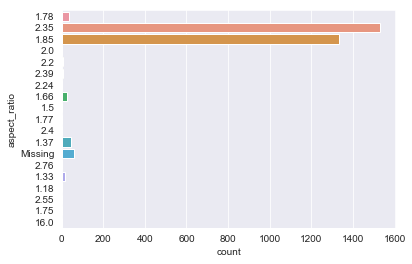

In [50]:
sns.countplot(y=abt.aspect_ratio)

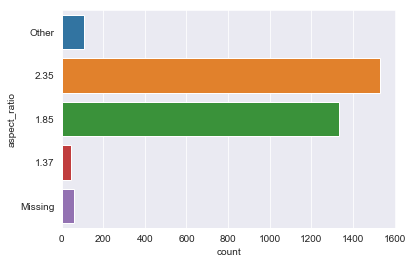

In [51]:
abt.aspect_ratio.replace(to_replace=[1.78, 2.0, 2.2, 2.39, 2.24, 1.66, 1.5, 1.77, 2.4, 2.76, 1.33, 1.18, 2.55, 1.75, 16.0], value='Other', inplace=True)
sns.countplot(y=abt.aspect_ratio)

In [52]:
abt.dtypes

color                              object
director_name                      object
num_critic_for_reviews            float64
duration                          float64
director_facebook_likes           float64
actor_3_facebook_likes            float64
actor_1_facebook_likes            float64
gross                             float64
actor_1_name                       object
num_voted_users                     int64
cast_total_facebook_likes           int64
num_user_for_reviews              float64
content_rating                     object
budget                            float64
actor_2_facebook_likes            float64
imdb_score                        float64
aspect_ratio                       object
movie_facebook_likes                int64
num_critic_for_reviews_missing      int64
duration_missing                    int64
actor_1_facebook_likes_missing      int64
actor_2_facebook_likes_missing      int64
actor_3_facebook_likes_missing      int64
Action                            

In [53]:
abt = pd.get_dummies(abt)

In [54]:
abt.head(10)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,num_user_for_reviews,budget,actor_2_facebook_likes,imdb_score,movie_facebook_likes,num_critic_for_reviews_missing,duration_missing,actor_1_facebook_likes_missing,actor_2_facebook_likes_missing,actor_3_facebook_likes_missing,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,color_ Black and White,color_Color,color_Missing,director_name_Barry Levinson,director_name_Bobby Farrelly,director_name_Clint Eastwood,director_name_David Fincher,director_name_Dennis Dugan,director_name_Francis Ford Coppola,...,director_name_Sam Raimi,director_name_Shawn Levy,director_name_Spike Lee,director_name_Steven Soderbergh,director_name_Steven Spielberg,director_name_Tim Burton,director_name_Tony Scott,director_name_Wes Craven,director_name_Woody Allen,actor_1_name_Bill Murray,actor_1_name_Brad Pitt,actor_1_name_Bruce Willis,actor_1_name_Channing Tatum,actor_1_name_Denzel Washington,actor_1_name_Dwayne Johnson,actor_1_name_Gerard Butler,actor_1_name_Harrison Ford,actor_1_name_Hugh Jackman,actor_1_name_J.K. Simmons,actor_1_name_Johnny Depp,actor_1_name_Joseph Gordon-Levitt,actor_1_name_Julia Roberts,actor_1_name_Keanu Reeves,actor_1_name_Kevin Spacey,actor_1_name_Leonardo DiCaprio,actor_1_name_Liam Neeson,actor_1_name_Matt Damon,actor_1_name_Matthew McConaughey,actor_1_name_Morgan Freeman,actor_1_name_Nicolas Cage,actor_1_name_Paul Walker,actor_1_name_Robert De Niro,actor_1_name_Robert Downey Jr.,actor_1_name_Robin Williams,actor_1_name_Steve Buscemi,actor_1_name_Tom Cruise,actor_1_name_Tom Hanks,actor_1_name_Will Ferrell,actor_1_name_Will Smith,content_rating_G,content_rating_Missing,content_rating_Other,content_rating_PG,content_rating_PG-13,content_rating_R,aspect_ratio_1.37,aspect_ratio_1.85,aspect_ratio_2.35,aspect_ratio_Missing,aspect_ratio_Other
0,723.0,178.0,0.0,855.0,1000.0,760505847.0,886204,4834,3054.0,237000000.0,936.0,7.9,33000,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,302.0,169.0,563.0,1000.0,40000.0,309404152.0,471220,48350,1238.0,300000000.0,5000.0,7.1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,1144337,106759,2701.0,250000000.0,23000.0,8.5,164000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
5,462.0,132.0,475.0,530.0,640.0,73058679.0,212204,1873,738.0,263700000.0,632.0,6.6,24000,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
6,392.0,156.0,0.0,4000.0,24000.0,336530303.0,383056,46055,1902.0,258000000.0,11000.0,6.2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
7,324.0,100.0,15.0,284.0,799.0,200807262.0,294810,2036,387.0,260000000.0,553.0,7.8,29000,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
8,635.0,141.0,0.0,19000.0,26000.0,458991599.0,462669,92000,1117.0,250000000.0,21000.0,7.5,118000,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
10,673.0,183.0,0.0,2000.0,15000.0,330249062.0,371639,24450,3018.

## Algorithm Selection

We will use a linear regression algorithm with Lasso, Ridge, and Elastic Net regularization. We'll also use two tree ensemble algorithms: random forests and boosted trees. These are the best common algorithms for regression tasks. 

## Model Training

In [59]:
# Split features from target variable, and split training and test data.

y = abt.gross
X = abt.drop('gross', axis=1)
print(y.shape, X.shape)

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3074,) (3074, 114)
(2459, 114) (615, 114) (2459,) (615,)


In [75]:
# Make a pipelines dictionary for the five algorithms selected, including Standardization in the pipelines

pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet' : make_pipeline(StandardScaler(), ElasticNet(random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
}

In [62]:
# Create hyperparameters dictionary for Lasso Regression
lasso_hyperparameters = {
    'lasso__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

In [63]:
# Create hyperparameters dictionary for Ridge Regression
ridge_hyperparameters = {
    'ridge__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

In [64]:
# Create hyperparameters dictionary for Elastic Net Regression
enet_hyperparameters = {
    'elasticnet__alpha': [0.0001, 0.001, 0.1, 1, 5, 10],
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [70]:
# Create hyperparameters dictionary for Random Forest Regression
rf_hyperparameters = {
    'randomforestregressor__n_estimators' : [100, 200],
    'randomforestregressor__max_features' : ['auto', 'sqrt', 0.5, 0.33, 0.2]
}

In [71]:
# Create hyperparameters dictionary for Gradient Boosting Regression
gb_hyperparameters = {
    'gradientboostingregressor__n_estimators' : [100, 200],
    'gradientboostingregressor__learning_rate' : [0.02, 0.05, 0.1, 0.2, 0.5],
    'gradientboostingregressor__max_depth' : [1, 3, 5]
}

In [72]:
# Create hyperparameters dictionary for all five algorithms
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters
}

In [76]:
# Create dictionary of fitted models
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted.')

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


lasso has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


ridge has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


enet has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


rf has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


gb has been fitted.


In [78]:
# Check that all items in fitted_models are the correct type
for name, model in fitted_models.items():
    print(name, type(model))

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [80]:
# Check that all items in fitted_models were fitted
for name, model in fitted_models.items():
    try: 
        model.predict(X_test)
        print(name, 'has can be predicted.')
    except NotFittedError as e:
        print(repr(e))

lasso has can be predicted.
ridge has can be predicted.
enet has can be predicted.
rf has can be predicted.
gb has can be predicted.


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to flo

In [81]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

lasso 0.6105838668132211
ridge 0.610530518624387
enet 0.6106410986449954
rf 0.7054995315513697
gb 0.7188774223628239


In [83]:
for name, model in fitted_models.items():
    pred=model.predict(X_test)
    print(name)
    print('---------')
    print('R^2:', r2_score(y_test, pred))
    print('MAE:', mean_absolute_error(y_test,pred))
    print()

lasso
---------
R^2: 0.6542008006921576
MAE: 29005703.711320646

ridge
---------
R^2: 0.6533121366602359
MAE: 29022969.691347323

enet
---------
R^2: 0.6535463184121977
MAE: 29014032.898831517

rf
---------
R^2: 0.7126563011741076
MAE: 24716511.824715447

gb
---------
R^2: 0.7172318667124713
MAE: 24404568.83419173



/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to flo

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


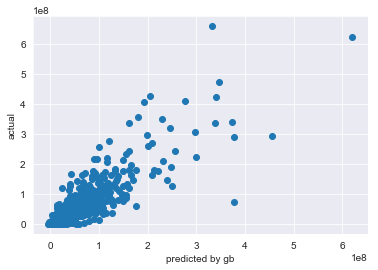

In [84]:
# Plotting gb predictions against actuals
gb_pred = fitted_models['gb'].predict(X_test)
plt.scatter(gb_pred, y_test)
plt.xlabel('predicted by gb')
plt.ylabel('actual')
plt.show()

## Insights & Analysis

The gradient boosting algorithm was the best model. It has an R^2 score of ~72%, pretty good, against both the testing and training data. It predicted movie gross to within ~24M, our goal was to predict scores to within 1/4 of the standard deviation of the profit of movies (~69), a win condition of ~17M. Let's take a look at the winning algorithm to see what we might learn about it. Also maybe we can tune the model a bit more to get under the win condition. Right now we are predicting to within 35 percent of one standard deviation of estimated profit margin.

In [86]:
fitted_models['gb'].best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, m...123, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))])

In [91]:
# Since the best values ended up being a learning_rate of 0.05, and a max_depth of 5, I will try a few more values nearby
gb_hyperparameters_ft = {
    'gradientboostingregressor__n_estimators' : [100, 200],
    'gradientboostingregressor__learning_rate' : [0.033, 0.05, 0.066, 0.75],
    'gradientboostingregressor__max_depth' : [4, 5, 7, 9]
}

gb_model = GridSearchCV(pipelines['gb'], gb_hyperparameters_ft, cv=10, n_jobs=-1)
gb_model.fit(X_train, y_train)
gb_pred_ft = gb_model.predict(X_test)
print('R^2:', r2_score(y_test, gb_pred_ft))
print('MAE:', mean_absolute_error(y_test, gb_pred_ft))
print(gb_model.best_estimator_)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


R^2: 0.7147880977701286
MAE: 24403582.191616513
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.066, loss='ls', max_depth=5,
             max_features=None, max_leaf_nodes=None,
...     subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False))])


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Not a huge improvement, nonetheless we're able to predict movie prices to within a fraction of a standard deviation of estimated profit margin, this should still help, and we were able to capture an R^2 score of 72% based on basic information about the movie including the name of the director and cast, director and cast facebook likes, and critical information. 

Some of these wouldn't be available before a movie came out so that makes the model less useful. I wonder if it is possible to predict gross to within one standard deviation even if we remove critical information: imdb score, number of user reviews, and number of critical reviews. 

In [94]:
abt_pre = abt.drop(columns = ['num_critic_for_reviews', 'num_voted_users', 'num_user_for_reviews', 'imdb_score'])
X_pre = abt_pre.drop(columns = ['gross'])
y_pre = abt.gross

(X_pre_train, X_pre_test, y_pre_train, y_pre_test) = train_test_split(X_pre, y_pre, test_size=0.2, random_state=1234)
print(X_pre_train.shape, X_pre_test.shape, y_pre_train.shape, y_pre_test.shape)

(2459, 110) (615, 110) (2459,) (615,)


In [100]:
fitted_models_pre = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    model.fit(X_pre_train, y_pre_train)
    fitted_models_pre[name] = model
    print(name, 'has been fitted.')

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


lasso has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


ridge has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


enet has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


rf has been fitted.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


gb has been fitted.


In [101]:
for name, model in fitted_models_pre.items():
    print(name, type(model))

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [102]:
for name, model in fitted_models_pre.items():
    try: 
        model.predict(X_pre_test)
        print(name, 'has can be predicted.')
    except NotFittedError as e:
        print(repr(e))

lasso has can be predicted.
ridge has can be predicted.
enet has can be predicted.
rf has can be predicted.
gb has can be predicted.


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to flo

In [103]:
for name, model in fitted_models_pre.items():
    pred=model.predict(X_pre_test)
    print(name)
    print('---------')
    print('R^2:', r2_score(y_pre_test, pred))
    print('MAE:', mean_absolute_error(y_pre_test,pred))
    print()

lasso
---------
R^2: 0.49931838103619997
MAE: 34377721.31137128

ridge
---------
R^2: 0.4984129637794107
MAE: 34358785.48021498

enet
---------
R^2: 0.49865728288734834
MAE: 34359875.78074347

rf
---------
R^2: 0.5809882590723332
MAE: 30897302.40704065

gb
---------
R^2: 0.5891104892117891
MAE: 30378141.617756207



/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to flo

Even without the critical information we were able to predict movie gross to within ~30M, less than half the standard deviation of estimated movie profti. 